In [1]:
from pathlib import Path
import os
compe='godaddy-microbusiness-density-forecasting'
iskaggle= os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if iskaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████████████████████████████████| 1.83M/1.83M [00:00<00:00, 10.8MB/s]

In [3]:
os.listdir(compe)

['census_starter.csv',
 'test.csv',
 'train.csv',
 'sample_submission.csv',
 'revealed_test.csv']

In [4]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [5]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')
df_starter=pd.read_csv(f'{compe}/census_starter.csv')
df_rtest=pd.read_csv(f'{compe}/revealed_test.csv')

In [28]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.01,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.88,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.06,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.99,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.99,1243


In [27]:
df_test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [30]:
df_starter.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.60,78.90,80.60,82.70,85.50,1001,14.50,15.90,16.10,16.70,...,1.30,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00
1,74.50,78.10,81.80,85.10,87.90,1003,20.40,20.70,21.00,20.20,...,1.40,1.30,1.40,1.00,1.30,52562,55962.00,58320,61756.00,64346.00
2,57.20,60.40,60.50,64.60,64.60,1005,7.60,7.80,7.60,7.30,...,0.50,0.30,0.80,1.10,0.80,33368,34186.00,32525,34990.00,36422.00
3,62.00,66.10,69.20,76.10,74.60,1007,8.10,7.60,6.50,7.40,...,1.20,1.40,1.60,1.70,2.10,43404,45340.00,47542,51721.00,54277.00
4,65.80,68.50,73.00,79.60,81.00,1009,8.70,8.10,8.60,8.90,...,1.30,1.40,0.90,1.10,0.90,47412,48695.00,49358,48922.00,52830.00


In [31]:
df_rtest.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.44,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.47,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.26,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.25,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.25,247


In [41]:
print('shape of train:',df.shape)
print('shape of test:',df_test.shape)
print('shape of starter:',df_starter.shape)
print('shape of rtest:',df_rtest.shape)
print('null values in train & test:',df.isna().sum().sum())

shape of train: (122265, 7)
shape of test: (25080, 3)
shape of starter: (3142, 26)
shape of rtest: (6270, 7)
null values in train & test: 0


In [42]:
cf=df['row_id'].str.split('_',expand=True)[0]
cf.value_counts()[0]

39

In [24]:
cf=df['first_day_of_month'].str.split('-',expand=True)[0]
print('Year\n',cf.value_counts())
print('\n')
cf=df['first_day_of_month'].str.split('-',expand=True)[1]
print('Month\n',cf.value_counts())

Year
 2020    37620
2021    37620
2022    31350
2019    15675
Name: 0, dtype: int64


Month
 08    12540
09    12540
10    12540
11     9405
12     9405
01     9405
02     9405
03     9405
04     9405
05     9405
06     9405
07     9405
Name: 1, dtype: int64


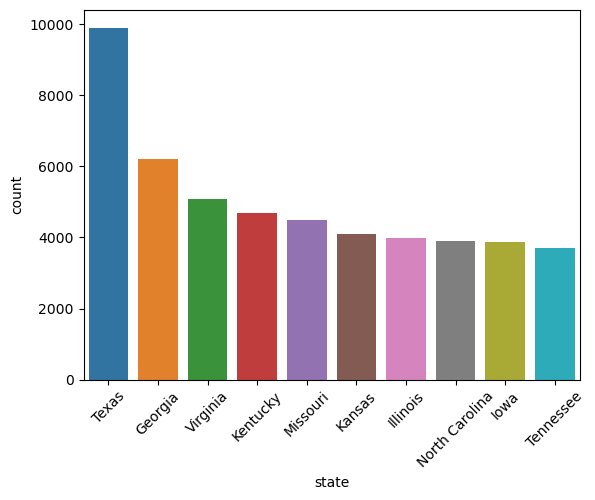

In [56]:
import seaborn as sns
# df.coun
counts = df['state'].value_counts()

# Get the n largest counts and their corresponding categories
n_largest_counts = counts.nlargest(10)
categories = n_largest_counts.index

# Plot the countplot
sns.countplot(data=df, x='state', order=categories)
plt.xticks(rotation=45)
plt.show()

In [61]:
df.describe()

,cfips,microbusiness_density,active
count,122265.00,122265.00,122265.00
mean,30376.04,3.82,6442.86
std,15143.51,4.99,33040.01
min,1001.00,0.00,0.00
25%,18177.00,1.64,145.00
50%,29173.00,2.59,488.00
75%,45077.00,4.52,2124.00
max,56045.00,284.34,1167744.00


In [70]:
df_test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


### Submission

In [63]:
import subprocess
def make_sub(pred_y,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['row_id']=df_test['row_id']
    df_submission['microbusiness_density']=pred_y
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')

In [64]:
df.microbusiness_density.describe()

count   122265.00
mean         3.82
std          4.99
min          0.00
25%          1.64
50%          2.59
75%          4.52
max        284.34
Name: microbusiness_density, dtype: float64

In [68]:
pred=np.full(len(df_test),2.59)

In [69]:
make_sub(pred_y=pred,name='intial_mode')

100%|██████████| 536k/536k [00:01<00:00, 520kB/s]  


400 - Bad Request
succesully saved - intial_mode
